In [9]:
import numpy as np
import networkx as nx
import pandas as pd
import scipy.linalg as LIN
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (12, 10)
plt.rcParams['font.weight'] = 'medium'

%matplotlib inline

In [10]:
np.random.seed(199)

In [21]:
# get left and right eigenvectors associated with the 
# largest eigenvalue. For a symmetric matrix, its left
# and right eigenvectors are the same. 
def getLREigVec(mat):
    eigVals_, eigL_, eigR_ = LIN.eig(mat, left=True)
    idx_max = np.argmax(eigVals_)
    t = eigL_[:, idx_max]
    h = eigR_[:, idx_max]
    return t, h

# compute gradient (Eq.(12) in the write-up)
def gradient(adjMat, S, Alpha, J):
    n = adjMat.shape[0]
    alpha1, alpha2, alpha3 = Alpha
    
    ## for 1st term, to increase the largest eigenvalue
    ## of the subgraph
    S_adjMat = adjMat[np.ix_(S, S)]
    # t_S, h_S: left, right eigenvectors of the subgraph, respectively
    mu_S, mu_S = getLREigVec(S_adjMat)
    g_1 = np.zeros(adjMat.shape)
    g_1[np.ix_(S, S)] = np.outer(mu_S, mu_S)
    g_1 = np.multiply(g_1, J)

    ## for 2nd term, to not increase the largest eigenvalue
    ## too much
    mu, mu = getLREigVec(adjMat)
    g_2 = np.outer(mu, mu)
    g_2 = np.multiply(g_2, J)

    ## for 3rd term, to increase the centrality of the subgraph
    x_S = np.zeros(len(G.nodes))
    x_S[S] = 1
    X_S = np.outer(x_S, x_S)
    P = np.transpose( 2 * X_S - (np.multiply(X_S, np.identity(n))) )
    g_3 = np.dot(np.multiply(P, np.identity(n)), np.ones((n, n))) - P
    g_3 = np.multiply(g_3, J)
    # no need to change the edges' weights within the subgraph
    g_3[np.ix_(S, S)] = 0
    
    return np.real( alpha1 * g_1 - alpha2 * g_2 + alpha3 / len(S) * g_3 )

# get the largest eigenvalue
def maxEig(mat):
    eigVals = LIN.eigvals(mat)
    return np.max(eigVals)

# get a submatrix of mat indexed by S
def getSubmat(mat, S):
    return mat[np.ix_(S, S)]

# get the Laplacian matrix corresponding to mat
def getL(mat):
    degsVec = np.dot(mat, np.ones(mat.shape[1]))
    return np.diag(degsVec) - mat

In [22]:
n = 20
G = nx.barabasi_albert_graph(n, 2)

In [23]:
adjMat = np.asarray(nx.adjacency_matrix(G).todense())
J = np.copy(adjMat)

In [24]:
# trade-off parameters
alpha1, alpha2, alpha3 = 0.5, 0.3, 0.2
ret = {'Lambda': [], 'Lambda_S': [], 'Centrality': [], 'Utility': []}
Gradient = []

# subgraph is the induced subgraph of S
S = [1, 2, 3]
x_S = np.zeros(len(G.nodes))
x_S[S] = 1

Iter = 100
lr = 0.1
adjMat_0 = np.copy(adjMat)

# gradient ascent 
for ii in range(Iter):
    # compute eigenvalues
    lambda_1 = np.real(maxEig(adjMat))
    lambda_1_S = np.real(maxEig(getSubmat(adjMat, S)))
    
    # compute centrality
    L = getL(adjMat)
    Cent = np.real( np.dot(x_S, np.dot(L, x_S)) / len(S) )
    
    # compute utility
    utility = np.real( alpha1 * lambda_1_S - alpha2 * lambda_1 + alpha3 * Cent )
    
    # printing and recording intermediate results
    if ii % 10 == 0:
        print("Lambda_S: %.4f      Lambda: %.4f      Centrality: %i      Utility: %.4f" % (lambda_1_S, lambda_1, Cent, utility))
    ret['Lambda'].append(lambda_1)
    ret['Lambda_S'].append(lambda_1_S)
    ret['Centrality'].append(Cent)
    ret['Utility'].append(utility)
    
    # update gradient
    g = gradient(adjMat, S, [alpha1, alpha2, alpha3], J)
    Gradient.append(np.copy(g))
    adjMat = adjMat + lr * g

# convert results into DataFrame
ret = pd.DataFrame(ret)

Lambda_S: 2.0000      Lambda: 4.6820      Centrality: 3      Utility: 0.3287
Lambda_S: 2.2680      Lambda: 4.7218      Centrality: 3      Utility: 0.4831
Lambda_S: 2.5224      Lambda: 4.7773      Centrality: 3      Utility: 0.6249
Lambda_S: 2.7633      Lambda: 4.8460      Centrality: 4      Utility: 0.7551
Lambda_S: 2.9912      Lambda: 4.9256      Centrality: 4      Utility: 0.8752
Lambda_S: 3.2071      Lambda: 5.0137      Centrality: 4      Utility: 0.9866
Lambda_S: 3.4122      Lambda: 5.1086      Centrality: 4      Utility: 1.0908
Lambda_S: 3.6078      Lambda: 5.2086      Centrality: 4      Utility: 1.1891
Lambda_S: 3.7951      Lambda: 5.3127      Centrality: 4      Utility: 1.2827
Lambda_S: 3.9754      Lambda: 5.4199      Centrality: 5      Utility: 1.3724


Text(0.5, 0, 'iterations')

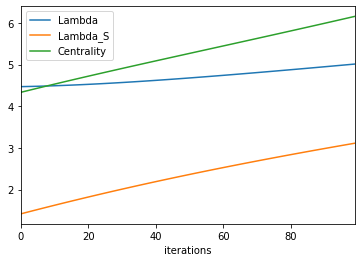

In [20]:
# plot results
ret[['Lambda', 'Lambda_S', 'Centrality']].plot(kind='line')
plt.xlabel('iterations')